Import packages and codes to be used 


In [1]:
%matplotlib inline
import numpy as np
import sympy as sp
import scipy as scipy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#Import Boundary.py where the boundary geometric features are defined
#from Boundary import *

In [2]:
#function to compute Gauss-Legendre nodes and weights
# Compute the Gauss Legendre quadrature points and weights using
# the method given in Spectral Methods in MATLAB by L. N. Trefethen (2000).
#
# Following implementation in Matlab by A. D. Kim.

def GaussLegendre(N):
    #N: number of nodes 
    
    beta = np.zeros(N-1)
    
    for i in range(1, N):
        beta[i-1]  = 0.5 / np.sqrt( 1.0 - (1 / ( 2.0 * i )**2) );
        
    T = np.diag(beta, k=1) + np.diag(beta, k=-1) 
    x, v = np.linalg.eig(T)
    i = np.argsort(x)
    x = x[i]
    w = 2.0 * v[0,i]**2
    
    return x, w
    

In [3]:
#functions that compute properties of the surface - currently just a sphere 

def SphereRotation( s, t, theta0, phi0 ):
# This function computes the rotation from the (s,t) angles on the unit
# sphere to the (theta,phi) angles on the unit sphere. See Appendix A of
# Carvalho, Khatri, and Kim (2020) for the mathematical details.
#
# Following implementation in Matlab by A. D. Kim 

    #compute the auxilliary variables

    xi   = ( np.cos( theta0 ) * np.cos( phi0 ) * np.sin( s ) * np.cos( t ) 
            - np.sin( phi0 ) * np.sin( s ) * np.sin( t ) 
            + np.sin( theta0 ) * np.cos( phi0 ) * np.cos( s ) )

    eta  = ( np.cos( theta0 ) * np.sin( phi0 ) * np.sin( s ) * np.cos( t ) 
            + np.cos( phi0 ) * np.sin( s ) * np.sin( t ) 
            + np.sin( theta0 ) * np.sin( phi0 ) * np.cos( s ) )

    zeta = - np.sin( theta0 ) * np.sin( s ) * np.cos( t ) + np.cos( theta0 ) * np.cos( s )

    #compute the rotated angles

    theta = np.arctan2( np.sqrt( xi**2 + eta**2 ), zeta )
    phi   = np.arctan2( eta, xi );

    return theta, phi

def ComputeSurface(s,t):
    
    a = 1.
    b = 1.5
    c = 2.
    
    #surface vector
    x = a*np.sin( s ) * np.cos( t ) # this is an ellipsoid now
    y = b*np.sin( s ) * np.sin( t )
    z = c*np.cos( s )
    
    #outward point normal vector
    nx = x/a**2 
    ny = y/b**2 
    nz = z/c**2 

    mag = np.sqrt(nx**2+ny**2+nz**2)
    
    nx = nx/mag
    ny = ny/mag
    nz = nz/mag
    
    #Jacobian of the mapping of the surface to a sphere 
    #J = 0*s + 1.0 
    bcx = b*c*x/a
    acy = a*c*y/b
    abz = a*b*z/c
    
    J = np.sqrt(bcx**2+acy**2+abz**2)
    
    return x, y, z, nx, ny, nz, J

    
def ComputeSurfaceRotation(s, t, theta0, phi0 ):
        
    theta, phi = SphereRotation( s, t, theta0, phi0 );

    x, y, z, nx, ny, nz, J = ComputeSurface(theta,phi)
    
    return theta, phi, x, y, z, nx, ny, nz, J

Discretization

In [4]:
#Gauss - Legendre 
M = 8
z, w = GaussLegendre(M)
s = np.arccos(z)

#Trapezoid Rule 
N = 2*M 
LN = 2*np.pi
dt = LN/N
t = np.linspace(-np.pi, -np.pi+LN, N, endpoint=False) 

sM, tM = np.meshgrid(s, t, sparse=False, indexing='ij')
sV = sM.flatten()
tV = tM.flatten()

wV = np.full(M*N, 0.0)
counter = 0 
for i, wi in enumerate(w):
    for j, tj in enumerate(t):
        wV[counter] = w[i]
        counter = counter+1 


Plot the domain 

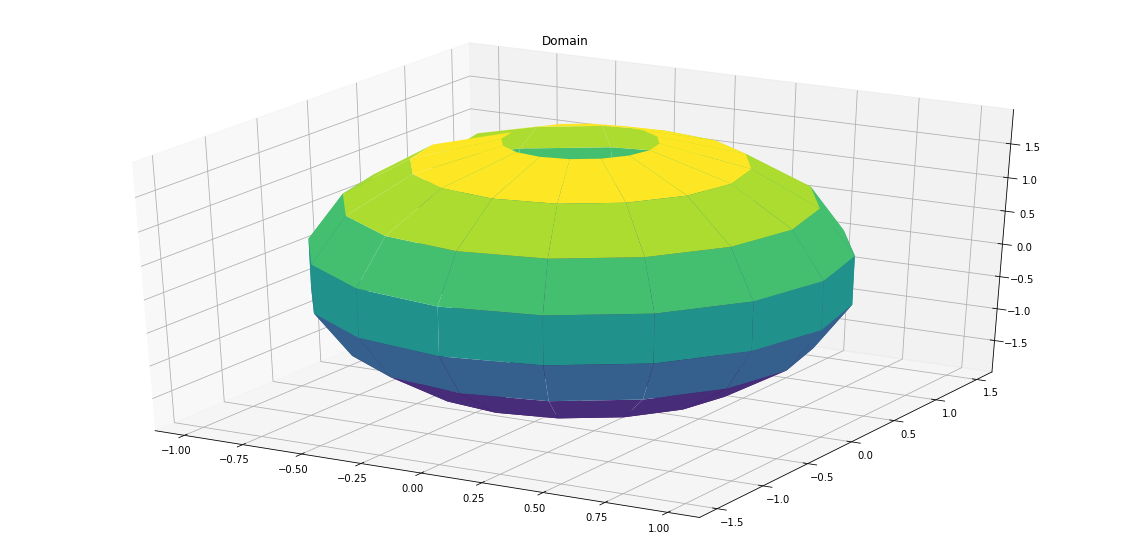

In [5]:
#only used to plot surface 
y00, y10, y20, n00, n10, n20, J0 = ComputeSurface(sV, tV)

y0M = np.reshape(y00,(M,N))
y1M = np.reshape(y10,(M,N))
y2M = np.reshape(y20,(M,N))

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.set_title('Domain')
#ax.contour3D(y0M, y1M, y2M, 50, cmap='binary')
ax.plot_surface(y0M, y1M, y2M, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

In [6]:
#functions for computing the kernel 

#evaluation of kernel given x and y, normal at y, Jacobian of mapping at y 
def evaluateK(y0, y1, y2, ny0, ny1, ny2, Jy, x0, x1, x2):

    rdiff = [x0 - y0, x1 - y1, x2 - y2]
    r_distance = np.sqrt(rdiff[0]**2 + rdiff[1]**2 + rdiff[2]**2)
    
    evalK = (Jy * ( ny0*rdiff[0] + ny1*rdiff[1] + ny2*rdiff[2] ) / ( r_distance**3 * 4 * np.pi ) )
    
    return evalK

#kernel evaluation if both points lie on the surface 
def K(s , t , theta0 , phi0):
    
    theta, phi, y0, y1, y2, ny0, ny1, ny2, Jy = ComputeSurfaceRotation(s, t, theta0, phi0 ) 
    x0, x1, x2, nx0, nx1, nx2, Jx = ComputeSurface(theta0, phi0)

    evalK = evaluateK(y0, y1, y2, ny0, ny1, ny2, Jy, x0, x1, x2)
    
    return theta, phi, evalK

#kernel evaluation if one point does not lie on the surface 
#Note theta0, phi0 needs to correspond to (x0, x1, x2)
def Koff(s, t, theta0, phi0, x0, x1, x2):

    theta, phi, y0, y1, y2, ny0, ny1, ny2, Jy = ComputeSurfaceRotation(s, t, theta0, phi0 ) 
    
    evalK = evaluateK(y0, y1, y2, ny0, ny1, ny2, Jy, x0, x1, x2)
    
    return theta, phi, evalK    
    
    
def ff(x0,x1,x2):

    return np.exp(x0)*np.cos(x1) + np.exp(x2)*np.sin(x0)

def RHSf(theta0 , phi0):
    
    x0, x1, x2, nx0, nx1, nx2, Jx = ComputeSurface( theta0, phi0)
    
    evalf = ff(x0,x1,x2)
    
    return evalf 
    
    #Other possible solutions:
    
    #return -1 
    
    #x00 = 5
    #y00 = 4
    #z00 = 3
    #ulen = np.sqrt( ( x0 - x00 )**2 + ( x1 - y00 )**2 + ( x2 - z00 )**2 )    
    #return 1/ulen


Solving the BIE

In [7]:
#Compute spherical harmonics matrix of order M 

Smk = np.zeros((M**2,N*M),dtype=np.complex_) #np.full((M**2,N*M), np.nan)

for j in range(0, N*M):
    
    counter = 0 
    
    for mm in range (0, M):
        for k in range (0, (2*mm) + 1):
        
            kindex = k - mm 
            Smk[counter,j] = scipy.special.sph_harm(kindex, mm, tV[j], sV[j] ) 
            
            counter = counter + 1
            


In [8]:
#Solving the BIE
#Notes:
#Using (M-1)st order for the spherical harmonic representation of the density - therefore we have M^2 spherical harmonics 

innerK = np.zeros((M**2,N*M),dtype=np.complex_)
kernel = np.zeros((M**2,M**2),dtype=np.complex_)
g = np.zeros(M**2,dtype=np.complex_)
mu = np.zeros(N*M,dtype=np.complex_)
mureal = np.zeros(N*M)
#Solving the BIE
#Notes:
#Using (M-1)st order for the spherical harmonic representation of the density - therefore we have M^2 spherical harmonics 

innerK = np.zeros((M**2,N*M),dtype=np.complex_)
kernel = np.zeros((M**2,M**2),dtype=np.complex_)
g = np.zeros(M**2,dtype=np.complex_)
mu = np.zeros(N*M,dtype=np.complex_)
mureal = np.zeros(N*M)

counter = -1

#First Inner product 

#looping over spherical harmonics (SK in my notes: mu kappa)
for mm in range (0, M):
    for kk in range (0, (2*mm) + 1):
        
        kkindex = kk - mm
        
        #counts the spherical harmonics functions from 0 to M^2-1 
        counter = counter + 1 
    
        #looping over all theta0 and phi0 values 
        for k in range (0,N*M):
            
            theta0 = sV[k]
            phi0 = tV[k]
            
            Smk2 = scipy.special.sph_harm( kkindex, mm, phi0, theta0 )  
        
            #loop to be able to sum the quadrature 
            for j in range (0,N*M):
        
                theta, phi, tempK = K( sV[j], tV[j], theta0, phi0 )
            
                Smk1 = scipy.special.sph_harm( kkindex, mm, phi, theta )  
                    
                innerK[counter,k] = innerK[counter,k] + np.pi*wV[j]*tempK*(Smk1-Smk2)/M
            
            innerK[counter,k] = innerK[counter,k] - Smk2/2
        
#Second Inner Product 

#loop over all spherical harmonics (SK in my notes: m k)
for i in range(0,M**2):
    
    #loop over all spherical harmonics (SK in my notes: mu kappa)
    for j in range(0, M**2):
        
        #loop to be able to sum the quadrature 
        for k in range(0,N*M): 
             
            kernel[i,j] = kernel[i,j] + np.pi*innerK[j,k]*wV[k]*Smk[i,k]/M

#RHS     

#loop over all spherical harmonics (SK in my notes: m k)
for i in range(0, M**2):
    
    #loop to be able to sum the quadrature 
    for k in range(0,N*M):
    
        g[i] = g[i] + np.pi*RHSf(sV[k],tV[k])*wV[k]*Smk[i,k]/M

A =  - 0.5 * np.identity(M**2) + kernel  
alpha = np.linalg.solve(A, g)

#Computing the density 
#for i in range(0, N*M):
#    
#    for j in range(0,M**2):
#
#            mu[i] = mu[i] + alpha[j]*Smk[j,i]
#            
#mureal = np.real(mu) 

counter = -1

#First Inner product 

#looping over spherical harmonics (SK in my notes: mu kappa)
for mm in range (0, M):
    for kk in range (0, (2*mm) + 1):
        
        kkindex = kk - mm
        
        #counts the spherical harmonics functions from 0 to M^2-1 
        counter = counter + 1 
    
        #looping over all theta0 and phi0 values 
        for k in range (0,N*M):
            
            theta0 = sV[k]
            phi0 = tV[k]
            
            Smk2 = scipy.special.sph_harm( kkindex, mm, phi0, theta0 )  
        
            #loop to be able to sum the quadrature 
            for j in range (0,N*M):
        
                theta, phi, tempK = K( sV[j], tV[j], theta0, phi0 )
            
                Smk1 = scipy.special.sph_harm( kkindex, mm, phi, theta )  
                    
                innerK[counter,k] = innerK[counter,k] + np.pi*wV[j]*tempK*(Smk1-Smk2)/M
            
            innerK[counter,k] = innerK[counter,k] - Smk2/2
        
#Second Inner Product 

#loop over all spherical harmonics (SK in my notes: m k)
for i in range(0,M**2):
    
    #loop over all spherical harmonics (SK in my notes: mu kappa)
    for j in range(0, M**2):
        
        #loop to be able to sum the quadrature 
        for k in range(0,N*M): 
             
            kernel[i,j] = kernel[i,j] + np.pi*innerK[j,k]*wV[k]*Smk[i,k]/M

#RHS     

#loop over all spherical harmonics (SK in my notes: m k)
for i in range(0, M**2):
    
    #loop to be able to sum the quadrature 
    for k in range(0,N*M):
    
        g[i] = g[i] + np.pi*RHSf(sV[k],tV[k])*wV[k]*Smk[i,k]/M

A =  - 0.5 * np.identity(M**2) + kernel  
alpha = np.linalg.solve(A, g)

#Computing the density 
#for i in range(0, N*M):
#    
#    for j in range(0,M**2):
#
#            mu[i] = mu[i] + alpha[j]*Smk[j,i]
#            
#mureal = np.real(mu) 


Solving for the solution

In [9]:
Nr = 8
#ar = np.linspace(1., 0.5, Nr)
#br = np.linspace(1.5,1.,Nr)
#cr = np.linspace(2.,1.5,Nr)
r = np.linspace(1.,0.5,Nr)

yvalues = np.linspace(0,127,32)  #can be up to N*M-1 
yvalues = yvalues.astype(int)
Ny = yvalues.size

x0 = np.full((Nr,Ny), np.nan)
x1 = np.full((Nr,Ny), np.nan)
x2 = np.full((Nr,Ny), np.nan)
u = np.zeros((Nr,Ny),dtype=np.complex_)
erroru = np.zeros((Nr,Ny),dtype=np.complex_)
exactu = np.full((Nr,Ny), np.nan)
ureal =np.full((Nr,Ny), np.nan)
errorureal =np.full((Nr,Ny), np.nan)

#Looping over x values 
for i in range(len(r)): 
    for j in range(len(yvalues)):   
        theta0 = sV[yvalues[j]]
        phi0 = tV[yvalues[j]]
        y0, y1, y2, n0, n1, n2, J = ComputeSurface(theta0, phi0)
        
        #Compute x value at where the solution will be evaluated
        x0[i,j] = y0 - n0*r[i]#n0*ar[i]
        x1[i,j] = y1 - n1*r[i]#n1*br[i]
        x2[i,j] = y2 - n2*r[i]#n2*cr[i]
        
        #computes mu for theta0/phi0 
        mu2 = 0 
        for mm in range (0,M**2):
            mu2 = mu2 + alpha[mm]*Smk[mm,yvalues[j]]
            
        #loop to be able to sum the quadrature 
        for k in range (0,N*M):
        
            theta, phi, tempK = Koff( sV[k], tV[k], theta0, phi0, x0[i,j], x1[i,j], x2[i,j] )
            
            #computes mu for rotated theta/phi
            mu1 = 0 
            counter = 0 
            for mm in range (0, M):
                for kk in range (0, (2*mm) + 1):
                    kindex = kk - mm 
                    mu1 = mu1 + alpha[counter]*scipy.special.sph_harm(kindex, mm, phi, theta )
                    counter = counter + 1   
            
            u[i,j] = u[i,j] + np.pi*tempK*wV[k]*(mu1-mu2)/M
        
        u[i,j] = u[i,j] - mu2 
        exactu[i,j] = ff(x0[i,j],x1[i,j],x2[i,j])
        erroru[i,j] = exactu[i,j]-u[i,j]    
       
        print("x: (%5.3f, %5.3f, %5.3f), \t u:%f \t erroru:%5.12f" % 
              (x0[i,j], x1[i,j], x2[i,j],  np.real(u[i,j]), abs(np.real(erroru[i,j])) ) )
             
        
ureal = np.real(u)
errorureal = np.abs(np.real(erroru))

        

x: (0.223, -0.000, -1.056), 	 u:1.324243 	 erroru:0.003167965368
x: (-0.000, -0.057, -0.988), 	 u:0.998649 	 erroru:0.000288419852
x: (-0.223, 0.000, -1.056), 	 u:0.725548 	 erroru:0.002836949555
x: (-0.000, 0.057, -0.988), 	 u:0.998649 	 erroru:0.000288419852
x: (0.231, -0.000, -1.043), 	 u:1.336779 	 erroru:0.003052950967
x: (-0.000, -0.195, -0.890), 	 u:0.981013 	 erroru:0.000055649093
x: (-0.231, 0.000, -1.043), 	 u:0.717460 	 erroru:0.003897922334
x: (-0.000, 0.195, -0.890), 	 u:0.981013 	 erroru:0.000055649093
x: (0.105, -0.000, -0.756), 	 u:1.161351 	 erroru:0.001912840334
x: (-0.000, -0.369, -0.631), 	 u:0.932483 	 erroru:0.000276265446
x: (-0.105, 0.000, -0.756), 	 u:0.850016 	 erroru:0.001515556160
x: (0.160, 0.398, -0.659), 	 u:1.167749 	 erroru:0.003407089173
x: (0.051, -0.299, -0.270), 	 u:1.044898 	 erroru:0.000131924786
x: (-0.147, -0.520, -0.239), 	 u:0.633244 	 erroru:0.000326122993
x: (-0.051, 0.299, -0.270), 	 u:0.868936 	 erroru:0.000145367140
x: (0.147, 0.520, -0.2

x: (0.080, -0.000, -1.303), 	 u:1.106615 	 erroru:0.001795046290
x: (-0.000, -0.160, -1.255), 	 u:0.987073 	 erroru:0.000076619875
x: (-0.080, 0.000, -1.303), 	 u:0.900576 	 erroru:0.000985419068
x: (-0.000, 0.160, -1.255), 	 u:0.987073 	 erroru:0.000076619875
x: (-0.008, -0.000, -1.200), 	 u:0.989966 	 erroru:0.000349645552
x: (-0.000, -0.399, -1.091), 	 u:0.921426 	 erroru:0.000158569721
x: (0.008, 0.000, -1.200), 	 u:1.010551 	 erroru:0.000103410952
x: (-0.000, 0.399, -1.091), 	 u:0.921426 	 erroru:0.000158569721
x: (-0.168, -0.000, -0.840), 	 u:0.772609 	 erroru:0.000199832312
x: (-0.000, -0.628, -0.751), 	 u:0.808920 	 erroru:0.000255917134
x: (0.168, 0.000, -0.840), 	 u:1.255735 	 erroru:0.000152698993
x: (0.021, 0.621, -0.771), 	 u:0.841030 	 erroru:0.000352146281
x: (-0.223, -0.375, -0.298), 	 u:0.580050 	 erroru:0.000338151178
x: (0.002, -0.761, -0.276), 	 u:0.727716 	 erroru:0.000166077878
x: (0.223, 0.375, -0.298), 	 u:1.327492 	 erroru:0.000468460479
x: (-0.002, 0.761, -0.2

In [10]:
np.min(errorureal)

6.914927584089625e-06

In [11]:
np.max(errorureal)

0.025539467351555212